In [245]:
%load_ext autoreload 
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [246]:
import os
os.chdir('/Users/sebas/projects/metabolomics')
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

In [247]:
import dill
from src.load_data import LoadData
from sklearn.model_selection import train_test_split
from src.train_utils import TrainUtils
from src.preprocessor import Preprocessor
import pickle
import sys
from src.config import Config
from src.parser import Parser
from datetime import datetime
from src.loader_saver import LoaderSaver
from torch.utils.data import DataLoader
from src.weight_sampling import WeightSampling
from torch.utils.data import DataLoader, WeightedRandomSampler
import lightning.pytorch as pl
from pytorch_lightning.callbacks import ProgressBar
from src.losscallback import LossCallback
from src.transformers.embedder import Embedder

In [248]:
data_folder= '/Users/sebas/projects/data/'
dataset_path= data_folder +'merged_gnps_nist_20240207_gnps_nist_janssen_15_millions.pkl'

In [249]:
train_molecules=10**3
val_molecules=10**3

In [250]:
config=Config()

In [251]:
config.CHECKPOINT_DIR = './notebooks/pair_generation/results'

## Load spectrums

In [252]:
print("loading file")
# Load the dataset from the pickle file
with open(dataset_path, "rb") as file:
    dataset = dill.load(file)

molecule_pairs_train = dataset["molecule_pairs_train"]
molecule_pairs_val = dataset["molecule_pairs_val"]
molecule_pairs_test = dataset["molecule_pairs_test"]
uniformed_molecule_pairs_test = dataset["uniformed_molecule_pairs_test"]

loading file


In [253]:
all_spectrums_train= molecule_pairs_train.spectrums
all_spectrums_val = molecule_pairs_val.spectrums

In [254]:
all_spectrums_train[6].library

'GNPS-LIBRARY'

In [255]:
all_spectrums_train[0].identifier

'CCMSLIB00012060239'

In [256]:
all_spectrums_train[6].precursor_mz

45.0444

In [257]:
all_spectrums_train[6].mz_array

array([ 65.038582,  68.997108,  77.038582,  79.05423 ,  91.017838,
        93.033493,  95.049141, 121.028412, 125.023323, 147.044067,
       159.044067, 161.059708, 166.997498, 171.044067, 173.023315,
       185.023315, 187.038971, 193.013153, 199.038971, 215.03389 ,
       217.049545, 227.03389 , 243.028793])

## STEPS:
## 1) Get the standard smiles 
## 2) Get a table with standard smiles and corresponding indexes in terms of spectrums
## 3) Order standard smiles by mz
## 4) Run pair generation on it

* get the standard smiles

In [258]:
from rdkit import Chem
import numpy as np
import pandas as pd

In [259]:
from src.transformers.load_data_unique import LoadDataUnique
from src.transformers.CustomDatasetUnique import CustomDatasetUnique

In [260]:
molecule_pairs_train=TrainUtils.compute_all_tanimoto_results_unique(
    all_spectrums_train,
    max_combinations=train_molecules,
    use_tqdm=True,
    max_mass_diff=config.MAX_MASS_DIFF,
    min_mass_diff=config.MIN_MASS_DIFF,
)

Computing tanimoto results based on unique smiles
getting metadata
finished getting metadata
creating dummy spectra...
Starting computation of molecule pairs
2024-03-13 16:52:21.960339
Computing all the tanimoto results



Processing:   0%|                                                                                                                                                                          | 0/1000 [00:00<?, ?it/s]

Compute all the fingerprints
Number of workers: 15
Precomputing min and max index





0it [00:00, ?it/s]


1058it [00:00, 10572.17it/s]


2116it [00:00, 9849.10it/s] 


3298it [00:00, 10711.53it/s]


4523it [00:00, 11302.74it/s]


5748it [00:00, 11637.78it/s]


6976it [00:00, 11853.11it/s]


8191it [00:00, 11946.49it/s]


9388it [00:00, 10881.61it/s]


10495it [00:00, 10930.58it/s]


11601it [00:01, 10196.99it/s]


12667it [00:01, 10325.35it/s]


13884it [00:01, 10852.57it/s]


14982it [00:01, 10750.36it/s]


16066it [00:01, 10711.58it/s]


17263it [00:01, 11077.11it/s]


18482it [00:01, 11402.34it/s]


19702it [00:01, 11636.21it/s]


20914it [00:01, 11777.72it/s]


22332it [00:01, 12492.98it/s]


23778it [00:02, 13079.56it/s]


25088it [00:02, 12913.44it/s]


26420it [00:02, 13032.48it/s]


29889it [00:02, 12059.01it/s]

Processing: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:23<00:00, 42.00it/s]


Number of effective pairs retrieved: 1000 
2024-03-13 16:52:46.552962


In [261]:
molecule_pairs_train.spectrums_original[0].intensity

array([1.59074997e+02, 1.54787155e+02, 4.10431023e+01, 4.40007751e+02,
       8.32647095e+01, 8.44405957e+03, 4.97812500e+01, 9.35955887e+01,
       3.45208321e+01, 4.64705887e+01, 3.98522720e+01, 8.20322189e+01,
       5.05235519e+01, 2.47280151e+02, 5.36406250e+01, 5.28125000e+01,
       7.27202377e+01, 4.83157883e+01, 2.60709351e+02, 9.09919739e+01,
       4.92915924e+02, 5.12857132e+01, 6.03130737e+02, 4.53703690e+01,
       1.82883728e+02, 3.12469521e+01, 3.82500000e+01, 2.74118469e+02,
       7.60658569e+01, 1.68852814e+02, 2.31335861e+02, 3.95104179e+01,
       3.50131226e+02, 9.37826080e+01, 1.14918579e+02, 1.19711540e+02,
       8.56149979e+01, 1.18784615e+02, 2.47543304e+02, 3.47323096e+03,
       3.78947372e+01, 3.12500000e+01, 3.25714302e+01, 6.63989453e+03,
       1.23001472e+02, 4.06124992e+01, 3.31570511e+01, 8.18678589e+01,
       7.60239334e+01, 3.42249985e+01, 2.04073532e+02, 3.50000000e+01,
       3.97372437e+01, 2.22500269e+03, 3.71250000e+01, 3.00489140e+01,
      

In [262]:
molecule_pairs_val=TrainUtils.compute_all_tanimoto_results_unique(
    all_spectrums_val,
    max_combinations=val_molecules,
    use_tqdm=True,
    max_mass_diff=config.MAX_MASS_DIFF,
    min_mass_diff=config.MIN_MASS_DIFF,
)

Computing tanimoto results based on unique smiles
getting metadata
finished getting metadata
creating dummy spectra...
Starting computation of molecule pairs
2024-03-13 16:52:51.039403
Computing all the tanimoto results



Processing:   0%|                                                                                                                                                                          | 0/1000 [00:00<?, ?it/s]

Compute all the fingerprints
Number of workers: 15
Precomputing min and max index





0it [00:00, ?it/s]


3712it [00:00, 25975.13it/s]

Processing: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 344.12it/s]

Number of effective pairs retrieved: 991 
2024-03-13 16:52:54.043418


## Extra operations

In [263]:
molecule_pairs_train = TrainUtils.compute_unique_combinations(molecule_pairs_train)

number of pairs: 29889


In [264]:
len(molecule_pairs_train)

30889

In [265]:
molecule_pairs_val = TrainUtils.compute_unique_combinations(molecule_pairs_val)

number of pairs: 3712


In [266]:
# create uniform test data
uniformed_molecule_pairs_val, _ = TrainUtils.uniformise(
    molecule_pairs_val,
    number_bins=config.bins_uniformise_INFERENCE,
    return_binned_list=True,
    bin_sim_1=False,
)  # do not treat sim==1 as another bin

In [267]:
len(uniformed_molecule_pairs_val)

130

In [268]:
## CALCULATION OF WEIGHTS
train_binned_list, _ = TrainUtils.divide_data_into_bins(
    molecule_pairs_train, config.bins_uniformise_TRAINING,
)

In [269]:
weights, range_weights = WeightSampling.compute_weights(train_binned_list)

In [270]:
weights

array([2.05293593e-02, 7.57305255e-03, 1.77493419e-02, 2.98936285e-02,
       6.55360317e-02, 1.00527246e-02, 2.88802851e-02, 1.00231578e-01,
       3.78652627e-01, 3.40787365e-01, 1.14006211e-04])

In [271]:
weights_tr = WeightSampling.compute_sample_weights(molecule_pairs_train, weights)
weights_val = WeightSampling.compute_sample_weights(molecule_pairs_val, weights)

In [272]:
dataset_train = LoadDataUnique.from_molecule_pairs_to_dataset(molecule_pairs_train, training=True)
# dataset_test = LoadData.from_molecule_pairs_to_dataset(m_test)
dataset_val = LoadDataUnique.from_molecule_pairs_to_dataset(molecule_pairs_val)

Preprocessing all the data ...



0it [00:00, ?it/s]
9325it [00:00, 93246.09it/s]
18650it [00:00, 92590.99it/s]
27910it [00:00, 91273.99it/s]
37040it [00:00, 90939.38it/s]
46135it [00:00, 90461.64it/s]
55182it [00:00, 89497.23it/s]
64134it [00:00, 88501.96it/s]
72987it [00:00, 87687.84it/s]
81758it [00:00, 83916.55it/s]
90178it [00:01, 83332.60it/s]
98729it [00:01, 83973.67it/s]
107142it [00:01, 83763.38it/s]
115529it [00:01, 83317.25it/s]
123868it [00:01, 82373.16it/s]
132111it [00:01, 81385.56it/s]
140255it [00:01, 78536.73it/s]
148128it [00:01, 78462.94it/s]
155988it [00:01, 77620.61it/s]
163759it [00:01, 76546.07it/s]
171421it [00:02, 75115.96it/s]
178940it [00:02, 73424.09it/s]
186291it [00:02, 72962.55it/s]
193592it [00:02, 71796.03it/s]
200776it [00:02, 70150.20it/s]
207797it [00:02, 69329.56it/s]
214734it [00:02, 68870.82it/s]
221623it [00:02, 67141.64it/s]
228343it [00:02, 65340.44it/s]
234886it [00:03, 63165.93it/s]
241216it [00:03, 60590.21it/s]
247295it [00:03, 58915.66it/s]
253201it [00:03, 56017.65it/s]


Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries
Preprocessing all the data ...



0it [00:00, ?it/s]
8887it [00:00, 88865.64it/s]
17774it [00:00, 86073.87it/s]
32605it [00:00, 75593.37it/s]


Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries


In [273]:
molecule_pairs_train.spectrums_original[0].intensity

array([1.59074997e+02, 1.54787155e+02, 4.10431023e+01, 4.40007751e+02,
       8.32647095e+01, 8.44405957e+03, 4.97812500e+01, 9.35955887e+01,
       3.45208321e+01, 4.64705887e+01, 3.98522720e+01, 8.20322189e+01,
       5.05235519e+01, 2.47280151e+02, 5.36406250e+01, 5.28125000e+01,
       7.27202377e+01, 4.83157883e+01, 2.60709351e+02, 9.09919739e+01,
       4.92915924e+02, 5.12857132e+01, 6.03130737e+02, 4.53703690e+01,
       1.82883728e+02, 3.12469521e+01, 3.82500000e+01, 2.74118469e+02,
       7.60658569e+01, 1.68852814e+02, 2.31335861e+02, 3.95104179e+01,
       3.50131226e+02, 9.37826080e+01, 1.14918579e+02, 1.19711540e+02,
       8.56149979e+01, 1.18784615e+02, 2.47543304e+02, 3.47323096e+03,
       3.78947372e+01, 3.12500000e+01, 3.25714302e+01, 6.63989453e+03,
       1.23001472e+02, 4.06124992e+01, 3.31570511e+01, 8.18678589e+01,
       7.60239334e+01, 3.42249985e+01, 2.04073532e+02, 3.50000000e+01,
       3.97372437e+01, 2.22500269e+03, 3.71250000e+01, 3.00489140e+01,
      

In [274]:
dataset_train=LoadDataUnique.from_molecule_pairs_to_dataset(molecule_pairs_train, training=True)

Preprocessing all the data ...



0it [00:00, ?it/s]
9313it [00:00, 93122.54it/s]
18626it [00:00, 91501.51it/s]
27779it [00:00, 91423.05it/s]
36923it [00:00, 90548.87it/s]
45980it [00:00, 90295.37it/s]
55011it [00:00, 89869.34it/s]
63999it [00:00, 89247.96it/s]
72925it [00:00, 88793.30it/s]
81805it [00:00, 87949.49it/s]
90602it [00:01, 87401.95it/s]
99343it [00:01, 87281.42it/s]
108072it [00:01, 86294.20it/s]
116704it [00:01, 85769.17it/s]
125283it [00:01, 84587.97it/s]
133745it [00:01, 83419.68it/s]
142091it [00:01, 81810.63it/s]
150278it [00:01, 80810.57it/s]
158363it [00:01, 80303.20it/s]
166396it [00:01, 78781.48it/s]
174279it [00:02, 76971.25it/s]
181984it [00:02, 76169.21it/s]
189605it [00:02, 74853.64it/s]
197094it [00:02, 73399.72it/s]
204438it [00:02, 72458.92it/s]
211686it [00:02, 72356.95it/s]
218923it [00:02, 70463.96it/s]
225977it [00:02, 67412.70it/s]
232743it [00:02, 66084.09it/s]
239368it [00:03, 63887.26it/s]
245774it [00:03, 61276.52it/s]
251923it [00:03, 58341.48it/s]
263328it [00:03, 76259.52it/s]


Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries


In [275]:
for i,n in enumerate(iter(dataset_train)):
    if i==13:
        print(n)
        break

{'mz_0': array([ 51.0227,  53.0383,  54.0335,  65.0383,  66.0461,  67.0413,
        67.0538,  68.0491,  77.0382,  78.0334,  79.0413,  91.0414,
        92.0492,  93.0569,  94.0645,  96.0439, 105.0443, 120.044 ,
       138.0547,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
         0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
         0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
         0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
         0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
         0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
         0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
         0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
         0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
         0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
         0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
         0.    ,   0.    ,   0.    ,   0.    ,   0.  

In [276]:
all_spectrums_train[0].precursor_mz

34.1505

In [277]:
all_spectrums_train[0].mz

array([ 100.077835,  105.032341,  105.327026,  109.063179,  115.052643,
        127.073921,  127.138062,  127.163506,  127.227669,  127.31855 ,
        127.503548,  128.061768,  135.813797,  141.067856,  141.511795,
        151.053009,  152.058472,  157.061447,  159.041275,  167.293732,
        169.061584,  173.057495,  175.073578,  176.031387,  181.062561,
        181.287781,  183.042953,  185.09465 ,  194.606079,  195.078247,
        197.05867 ,  198.068451,  199.074081,  200.052109,  201.049835,
        206.909241,  209.057098,  210.950867,  213.08696 ,  215.068237,
        215.145248,  215.404663,  215.694733,  217.083344,  217.141602,
        217.197739,  218.701523,  219.370956,  220.742996,  221.844757,
        223.073868,  223.271362,  224.629654,  225.052643,  225.273773,
        225.427597,  226.05986 ,  226.126984,  226.433975,  227.067688,
        227.190674,  227.254364,  227.315277,  227.526367,  227.741486,
        228.734421,  229.046234,  229.482483,  230.156799,  239.

In [278]:
train_sampler = WeightedRandomSampler(
    weights=weights_tr, num_samples=len(dataset_train), replacement=True
)
val_sampler = WeightedRandomSampler(
    weights=weights_val, num_samples=len(dataset_val), replacement=True
)


In [279]:
dataloader_train = DataLoader(
    dataset_train, batch_size=config.BATCH_SIZE,  num_workers=10, sampler=train_sampler,
)
def worker_init_fn(
    worker_id,
):  # ensure the dataloader for validation is the same for every epoch
    seed = 42
    torch.manual_seed(seed)
    # Set the same seed for reproducibility in NumPy and Python's random module
    np.random.seed(seed)
    random.seed(seed)

dataloader_val = DataLoader(
    dataset_val,
    batch_size=config.BATCH_SIZE,
    num_workers=0,
    sampler=val_sampler,
)


In [280]:
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    dirpath=config.CHECKPOINT_DIR,
    filename="best_model",
    monitor="validation_loss_epoch",
    mode="min",
    save_top_k=1,
)

# checkpoint_callback = SaveBestModelCallback(file_path=config.best_model_path)
progress_bar_callback = ProgressBar()

# loss callback
losscallback = LossCallback(file_path=config.CHECKPOINT_DIR + f"loss.png")

print("define model")


    
model = Embedder(
        d_model=int(config.D_MODEL),
        n_layers=int(config.N_LAYERS),
        weights=None,
        lr=config.LR,
        use_cosine_distance=config.use_cosine_distance,
    )

define model


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:639: Checkpoint directory /Users/sebas/projects/metabolomics/notebooks/pair_generation/results exists and is not empty.

  | Name                    | Type                             | Params
-----------------------------------------------------------------------------
0 | linear                  | Linear                           | 16.5 K
1 | linear_regression       | Linear                           | 129   
2 | fixed_linear_regression | FixedLinearRegression            | 129   
3 | relu                    | ReLU                             | 0     
4 | spectrum_encoder        | SpectrumTransformerEncoderCustom | 1.7 M 
5 | regression_loss         | MSELoss                          | 0     
6 | dropout                

Sanity Checking: |                                                                                            …

/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.
/Users/sebas/projects/metabolomics/src/transformers/spectrum_transformer_encoder_custom.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mass_precursor = torch.tensor(kwargs["precursor_mass"].float())
/Users/sebas/projects/metabolomics/src/transformers/spectrum_transformer_encoder_custom.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  charge_precursor = 

Train loss:
[]
Validation loss
[0.18778303265571594]


/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Training: |                                                                                                   …

Validation: |                                                                                                 …

Train loss:
[]
Validation loss
[0.18778303265571594, 0.07815444469451904]


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x2acb41bc0>
Traceback (most recent call last):
  File "/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1443, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/Users/sebas/miniconda3/envs/transformers/lib/python3.11/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/sebas/miniconda3/envs/transformers/lib/python3.11/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/sebas/miniconda3/envs/transformers/lib/python3.11/multiprocessing/connection.py", line 947, in wait
    ready = selector.

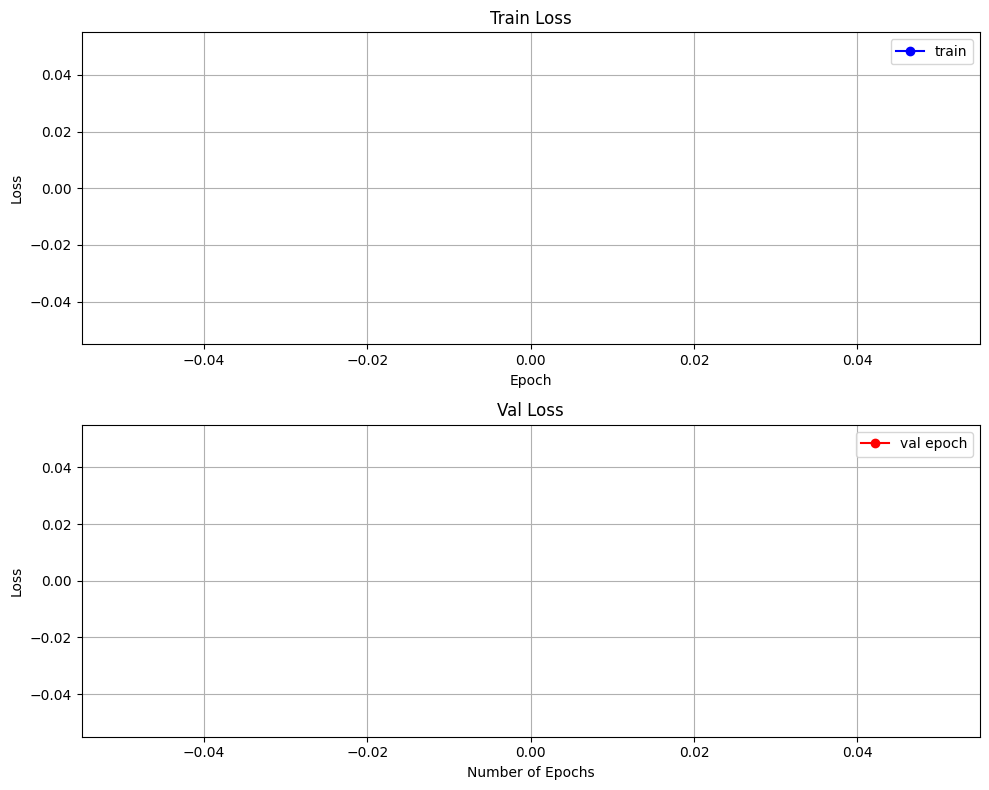

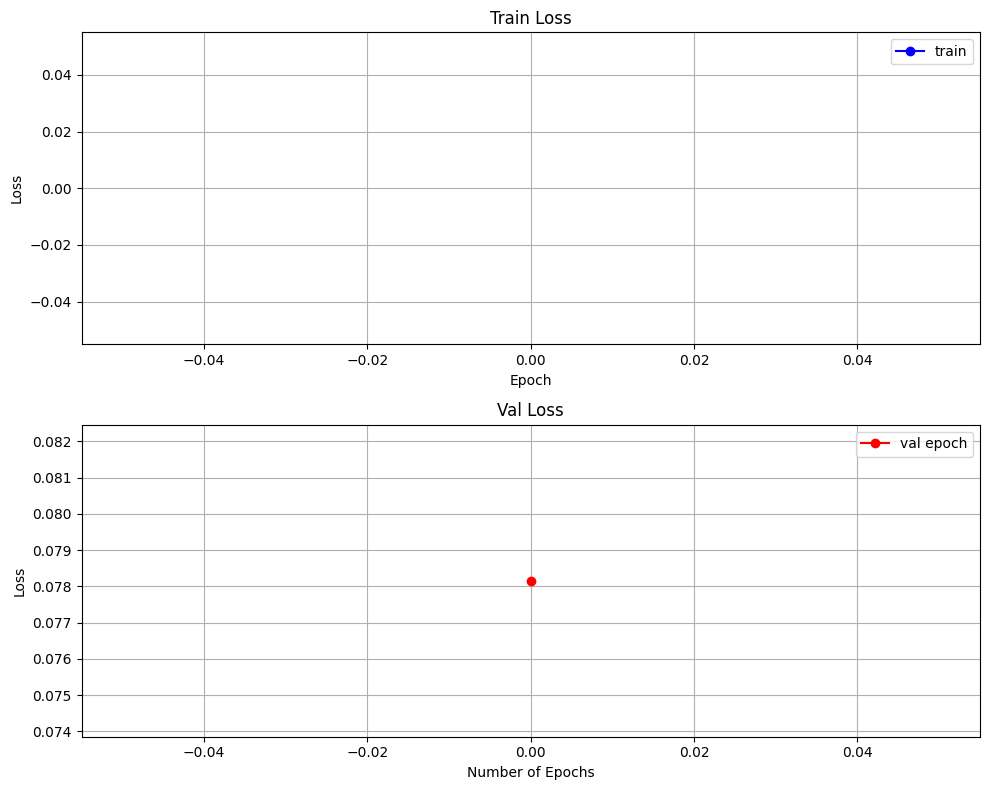

In [345]:
trainer = pl.Trainer(
    max_epochs=3,
    callbacks=[checkpoint_callback, losscallback],
    enable_progress_bar=True,
    # val_check_interval= config.validate_after_ratio,
)
# trainer = pl.Trainer(max_steps=100,  callbacks=[checkpoint_callback, losscallback], enable_progress_bar=enable_progress_bar)
trainer.fit(
    model=model,
    train_dataloaders=(dataloader_train),
    val_dataloaders=dataloader_val,
)

## Check the correct loading of data

In [349]:
weights= [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

In [357]:
def compute_sample_weights(sim, weights):
        index = [math.floor(s * (len(weights) - 1)) for s in sim]
        weights_sample = np.array([weights[ind] for ind in index])
        weights_sample = weights_sample
        return weights_sample

In [156]:
max_combinations=100

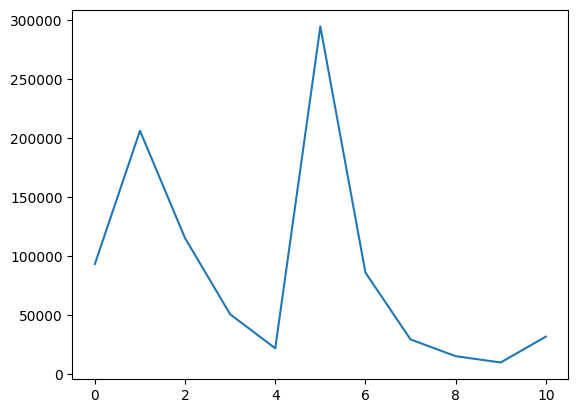

In [362]:
import matplotlib.pyplot as plt
plt.plot([93527, 206458, 115367, 50862, 21977, 294869, 86199, 29506, 15328, 9977, 31887])

In [150]:
all_spectrums_train

 ...]

In [234]:
spectrums_unique, df_smiles = TrainUtils.get_unique_spectra(all_spectrums_train)

getting metadata
finished getting metadata
creating dummy spectra...


In [235]:
df_smiles

,canon_smiles,indexes,number_indexes,mz,charge,library,inchi,ionmode,bms,superclass,classe,subclass
0,CCC(C)C1(O)CC(=O)c2c(cc3cccc(O)c3c2O)C1C(C)=O,[0],1,34.1505,1,GNPS-LIBRARY,InChI=1S/C20H22O5/c1-4-10(2)20(25)9-15(23)17-1...,Positive,CCC(C)C1(C)CC(C)C2C(C)C3C(C)CCCC3CC2C1C(C)C,None,None,None
1,N#C[O-],"[1, 2]",2,43.0058,1,HMDB,InChI=1S/CHNO/c2-1-3/h3H/p-1,Positive,CCC,None,None,None
2,CC=O,"[3, 4, 5]",3,45.0340,1,HMDB,"InChI=1S/C2H4O/c1-2-3/h2H,1H3",Positive,CCC,None,None,None
3,O=c1c2ccccc2oc2cc(O)c(O)c(O)c12,[6],1,45.0444,1,GNPS-LIBRARY,,Positive,CC1CC2CC3CCCCC3C(C)C2C(C)C1C,None,None,None
4,CC(C)=O,"[8, 10]",2,59.0497,1,HMDB,InChI=1S/C3H6O/c1-3(2)4/h1-2H3,Positive,CC(C)C,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...
29884,CC(C)CC(NC(=O)C(C)NC(=O)CNC(=O)C(NC=O)C(C)C)C(...,[263323],1,1859.0600,1,GNPS-LIBRARY,,Positive,CCCCC(C)C(CC(C)C(CC(C)C)CC(C)C(CC(C)C(CC(C)C)C...,None,None,None
29885,O=C(O)CC(=O)OCC1OC(Oc2cc3c(O)cc(O)cc3[o+]c2-c2...,[263324],1,2107.0000,1,RESPECT,InChI=1S/C96H106O53/c97-31-54-68(109)75(116)82...,Positive,CCC1CC(CC2CCC(CCC(C)CCC3CC(CC4CCC(CCC(C)CCC5CC...,None,None,None
29886,CC[C@@H](C)[C@H](NC(=O)C1CCCN1C(=O)[C@H](Cc1cc...,[263325],1,2157.1200,1,GNPS-LIBRARY,LWGFCRLDHIFNQK-OTDJLLNESA-N,Positive,CCC(C)C(CC(C)C1CCCC1C(C)C(CC1CCCCC1)CC(C)C(CC1...,None,None,None
29887,CC=C(NC(=O)C(CCCCN)NC(=O)C(C)NC(=O)C1CSC(C)C(N...,[263326],1,2164.9600,1,TUEBINGEN-NATURAL-PRODUCT-COLLECTION,N/A,Positive,CCCCCC(CC(C)C(C)CC(C)C1CCC(C)C(CC(C)C2CCCC(CC(...,None,None,None


In [236]:
from src.preprocessing_utils import PreprocessingUtils
all_spectrums = PreprocessingUtils.order_spectrums_by_mz(all_spectrums_train)

In [237]:
all_spectrums[0].precursor_mz

34.1505

In [238]:
from src.molecule_pairs_opt import MoleculePairsOpt
indexes_np = np.zeros((max_combinations, 3))
indexes_np = MoleculePairsOpt.adjust_data_format(np.array(indexes_np))
counter_indexes = 0

In [239]:
from tqdm import tqdm
print("Computing all the tanimoto results")
# Initialize tqdm with the total number of iterations
progress_bar = tqdm(total=max_combinations, desc="Processing")
# progress_bar = tqdm(total=len(all_spectrums), desc="Processing")
# Compute all the fingerprints:
print("Compute all the fingerprints")
fingerprints = TrainUtils.compute_all_fingerprints(all_spectrums)

Computing all the tanimoto results




Processing:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 99/100 [39:03<00:23, 23.67s/it]

Compute all the fingerprints


In [240]:
print(f"Number of workers: {1}")
counter_indexes = 0

# precompute min and max index
df_precomputed_indexes = TrainUtils.precompute_min_max_indexes(
            all_spectrums,
            min_mass_diff=config.MIN_MASS_DIFF,
            max_mass_diff=config.MAX_MASS_DIFF,
            use_tqdm=True,
        )

Number of workers: 1
Precomputing min and max index



0it [00:00, ?it/s]
218it [00:00, 2172.53it/s]
436it [00:00, 2027.60it/s]
640it [00:00, 1766.81it/s]
857it [00:00, 1906.49it/s]
1077it [00:00, 2004.55it/s]
1281it [00:00, 1999.22it/s]
1483it [00:00, 1995.70it/s]
1703it [00:00, 2057.97it/s]
1924it [00:00, 2102.36it/s]
2136it [00:01, 2067.92it/s]
2344it [00:01, 1861.88it/s]
2535it [00:01, 1818.96it/s]
2720it [00:01, 1718.31it/s]
2940it [00:01, 1848.81it/s]
3129it [00:01, 1723.44it/s]
3305it [00:01, 1645.27it/s]
3497it [00:01, 1717.10it/s]
3716it [00:01, 1847.31it/s]
3920it [00:02, 1901.03it/s]
4113it [00:02, 1765.14it/s]
4335it [00:02, 1888.99it/s]
4535it [00:02, 1917.87it/s]
4730it [00:02, 1762.80it/s]
4911it [00:02, 1680.04it/s]
5132it [00:02, 1821.99it/s]
5318it [00:02, 1729.98it/s]
5501it [00:02, 1756.97it/s]
5701it [00:03, 1822.79it/s]
5886it [00:03, 1740.40it/s]
6063it [00:03, 1677.36it/s]
6256it [00:03, 1745.79it/s]
6446it [00:03, 1787.62it/s]
6627it [00:03, 1716.61it/s]
6847it [00:03, 1852.36it/s]
7035it [00:03, 1748.66it/s]
7213

In [241]:
import random
while counter_indexes < max_combinations:

        # to use the whole range or only a small range?
        use_all_range = np.random.randint(0, 2)

        i = np.random.randint(0, len(all_spectrums) - 1)
        if use_all_range == 1:
            min_mz_index = 0
            max_mz_index = len(all_spectrums) - 1
        else:
            min_mz_index = df_precomputed_indexes.loc[i, "min_index"]
            max_mz_index = df_precomputed_indexes.loc[i, "max_index"]

        # get the other index
        j = random.randint(min_mz_index, max_mz_index)

        # Submit the task to the executor
        tani = Tanimoto.compute_tanimoto(
            fingerprints[i],
            fingerprints[j],
        )

        if tani is not None:
            # if tani>MIN_SIM and tani<MAX_SIM:
            if (counter_indexes < 0.5 * max_combinations) or (tani > 0.5):

                indexes_np[counter_indexes, 0] = i
                indexes_np[counter_indexes, 1] = j
                indexes_np[counter_indexes, 2] = tani
                counter_indexes = counter_indexes + 1
                if True:
                    progress_bar.update(1)




Processing:   1%|█▌                                                                                                                                                              | 1/100 [02:17<3:46:45, 137.43s/it]

In [242]:
# avoid duplicates:
indexes_np = np.unique(indexes_np, axis=0)

In [244]:
#let's take index 10
target_index=10
indexes_np[target_index]

array([8.22570000e+04, 2.28269000e+05, 1.58097686e-01])

In [215]:
index_0= indexes_tani[target_index][0]
index_0

689.0

In [216]:
index_1= indexes_tani[target_index][1]
index_1

6875.0

In [217]:
smiles_0=molecule_pairs_train.spectrums[int(index_0)].smiles
smiles_0

'C=C(CC[C@@]1(O)O[C@H]2C[C@H]3[C@@H]4CC[C@H]5C[C@@H](O)C[C@@H](O[C@@H]6OC[C@H](O)[C@H](O)[C@H]6O)[C@]5(C)[C@H]4CC[C@]3(C)[C@H]2[C@@H]1C)CO[C@@H]1O[C@H](CO)[C@@H](O)[C@H](O)[C@H]1O'

In [218]:
smiles_1=molecule_pairs_train.spectrums[int(index_1)].smiles
smiles_1

'CCC=CCC=CCC=CCCCCCCCC(=O)OC'

In [219]:
df= molecule_pairs_train.df_smiles
df[df['canon_smiles']==smiles_0]

,canon_smiles,indexes,number_indexes,mz,charge,library,inchi,ionmode,bms,superclass,classe,subclass
689,C=C(CC[C@@]1(O)O[C@H]2C[C@H]3[C@@H]4CC[C@H]5C[...,[259171],1,741.406,1,GNPS-LIBRARY,InChI=1S/C38H62O14/c1-17(15-48-34-33(46)31(44)...,Positive,CCC1CC(CCC(C)CCC2(C)CC3CC4C5CCC6CC(C)CC(CC7CCC...,None,None,None


In [225]:
molecule_pairs_train.spectrums_original[259171].smiles

'C[C@@]12[C@](CC[C@]3([H])[C@]2([H])CC[C@@]4(C)[C@@]3([H])C[C@@]5([H])[C@]4([H])[C@H](C)[C@](CCC(CO[C@@H]6O[C@H](CO)[C@@H](O)[C@H](O)[C@H]6O)=C)(O)O5)([H])C[C@@H](O)C[C@H]1O[C@@H]7OC[C@H](O)[C@H](O)[C@H]7O'

In [226]:
Chem.CanonSmiles(molecule_pairs_train.spectrums_original[259171].smiles)

'C=C(CC[C@@]1(O)O[C@H]2C[C@H]3[C@@H]4CC[C@H]5C[C@@H](O)C[C@@H](O[C@@H]6OC[C@H](O)[C@H](O)[C@H]6O)[C@]5(C)[C@H]4CC[C@]3(C)[C@H]2[C@@H]1C)CO[C@@H]1O[C@H](CO)[C@@H](O)[C@H](O)[C@H]1O'

In [227]:
from src.tanimoto import Tanimoto

In [228]:
fp0= Tanimoto.compute_fingerprint(smiles_0)

In [229]:
fp1= Tanimoto.compute_fingerprint(smiles_1)

In [230]:
Tanimoto.compute_tanimoto(fp0,fp1)

0.1037463976945245